In [2]:
# Imports
import numpy as np
import matplotlib.pylab as plt

### Generate Synthetic Data

In [ ]:
# Generate Data using Tyler's code
# c_response = fem_pipe(...)
# imag_response = np.imag(c_response)
# mu0 = 4 * np.pi * 1e-7
# omega = 2 * np.pi * frequencies
# apparent_conductivity = (4 / (mu0 * omega * (dipole_dist**2))) * imag_response

# Plot of Apprarent Conductivity vs Frequency with Horizontal Sounding as the y-axis

### Test Example Data

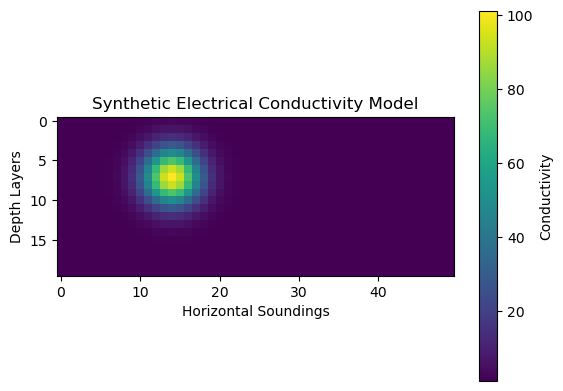

In [3]:
# Number of depth layers and horizontal soundings
num_layers = 20
num_soundings = 50

# Initialize the background conductivity model
conductivity = np.ones((num_layers, num_soundings))

# Create meshgrid for spatial coordinates
X, Y = np.meshgrid(np.arange(1, num_soundings + 1), np.arange(1, num_layers + 1))

# Define the anomaly parameters
center_x = 15  # Center of anomaly in the x-direction
center_y = 8   # Center of anomaly in the y-direction (depth)
radius = 5     # Radius of the anomaly

# Gaussian-like gradient for the circular anomaly
anomaly = np.exp(-((X - center_x) ** 2 + (Y - center_y) ** 2) / (0.5 * radius ** 2))

# Add the anomaly to the background model
conductivity += 100*anomaly

# Plot the conductivity model
plt.figure()
plt.imshow(conductivity, aspect='equal', origin='upper', cmap='viridis')
plt.colorbar(label='Conductivity')
plt.xlabel('Horizontal Soundings')
plt.ylabel('Depth Layers')
plt.title('Synthetic Electrical Conductivity Model')
plt.show()

### This would be replaced with Tyler's Generated Data

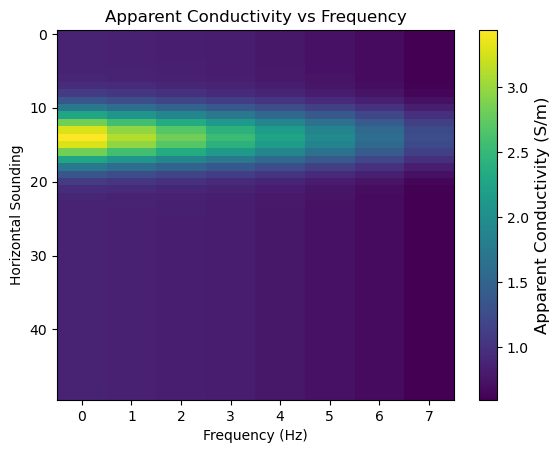

In [6]:
### Need to run the aconduct function first!

dipole_dist = 1
sensor_ht = 0.05
frequencies = np.logspace(3, 5, 8)  # Frequencies (Hz)
omega = 2 * np.pi * frequencies  # Convert to angular frequencies (rad/s)

# Compute apparent conductivity for each sounding
num_frequencies = len(frequencies)
apparent_conductivity = np.zeros((num_soundings, num_frequencies))  # Initialize result

for sounding in range(num_soundings):
    # Extract vertical profile for the current sounding
    sigma = conductivity[:, sounding]
    mu = np.ones(num_layers) * (4 * np.pi * 1e-7)  # Magnetic permeability (H/m)
    d = np.ones(num_layers)  # Thickness of each layer (m)
    d[-1] = np.inf  # Infinite thickness for the last layer

    # Compute apparent conductivity for this sounding
    mp = aconduct(sigma, mu, d, omega, np.array([dipole_dist]), np.array([sensor_ht]))
    mp = mp.flatten()  # Ensure mp is a 1D array
    # Store the results
    apparent_conductivity[sounding, :] = mp

# Plot apparent conductivity
plt.figure()
plt.imshow(apparent_conductivity, aspect='auto', origin='upper', cmap='viridis')
# plt.gca().invert_yaxis()  # Ensure soundings are oriented correctly
cb = plt.colorbar()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Horizontal Sounding')
plt.title('Apparent Conductivity vs Frequency')
cb.set_label('Apparent Conductivity (S/m)', fontsize=12)
plt.show()

### Set up inversion

In [5]:
import numpy as np
from hankelpts import hankelpts
from hankelwts import hankelwts

def reflfact(lambda_vals, sigma, mu, d, omega):
    lambda_vals = np.array(lambda_vals).flatten()
    sigma = np.array(sigma).flatten()
    mu = np.array(mu).flatten()
    omega = np.array(omega).flatten()

    n = len(sigma)     # Number of layers
    q = len(lambda_vals)
    nfreq = len(omega)  # Number of frequencies
    mu0 = np.pi * 4e-7  # Permeability of free space

    # Compute constants
    # Equivalent computations
    den0 = 1j * mu0 * omega
    densig = np.outer(mu, omega) + 1j * 1e-12
    frac = -1j / (densig  + 1e-12)
    densig = sigma[:, None] * densig

    # Initialize Y (last layer)
    lam2 = np.tile(lambda_vals[:, None] ** 2, (1, nfreq))
    u = np.sqrt(lam2 + 1j * np.tile(densig[-1, :], (q, 1)))
    Y = u * np.tile(frac[-1, :], (q, 1))

    # Backward recurrence to compute Y for all layers
    for k in range(n-2, -1, -1):
        u = np.sqrt(lam2 + 1j * np.tile(densig[k, :], (q, 1)))
        N = u * np.tile(frac[k, :], (q, 1))
        arg = np.minimum(np.abs(u * d[k]), 300) * np.sign(u * d[k])
        tan_ip = np.tanh(arg)

        Aden = N + Y * tan_ip
        Aden = np.where(np.abs(Aden) < 1e-12, 1e-12 + 1j * 1e-12, Aden)
        A = (Y + N * tan_ip) / Aden
        Y = N * A  # Update Y for layer k

    # Compute reflection factor R0
    N0 = lambda_vals[:, None] / den0
    R0 = (N0 - Y) / (N0 + Y)
    return R0

def aconduct(sigma, mu, d, omega, R, h):
    """
    Compute the apparent conductivity for 'horizontal' orientation and 'sigma' case.
    
    Parameters:
        sigma  - array of conductivities per layer (S/m)
        mu     - array of magnetic permeabilities per layer (H/m)
        h      - array of heights above ground (m)
        d      - array of layers thickness (m)
        R      - array of intercoil (IC) spacings (m)
        omega  - array of angular frequencies (rad/s)
    
    Returns:
        mp  - Predicted readings with coils horizontally oriented
    """
    sigma = np.array(sigma).flatten()
    mu = np.array(mu).flatten()
    R = np.array(R).flatten()
    omega = np.array(omega).flatten()
    n = len(sigma)
    m = len(h)
    nR = len(R)
    nfreq = len(omega)
    nhf = m * nfreq
    mu0 = np.pi * 4e-7
    
    w0, w1 = hankelwts()  # Get weights for Hankel transform
    y = hankelpts()  # Get nodes for Hankel transform
    
    T2 = np.zeros((m, nfreq))
    mp = np.zeros(nR * nhf)
    
    for k in range(nR):
        yh = y / R[k]
        rf = reflfact(yh, sigma, mu, d, omega)
        rf = np.imag(rf)
        rf *= yh[:, None]
        for i in range(m):
            f = rf * np.exp(-2 * yh[:, None] * h[i])
            T2[i, :] = np.dot(w1, f) / R[k]

        f1 = 4 / (mu0 * omega)
        mht = -np.outer(f1, np.ones(m)).T * T2
        mp[k * nhf:(k + 1) * nhf] = mht.T.flatten()
    return mp


In [7]:
def compute_apparent_conductivity(sigma, frequencies, dipole_dist=dipole_dist, sensor_ht = sensor_ht):
    num_layers = len(sigma)
    mu = np.ones(num_layers) * (4 * np.pi * 1e-7)
    d = np.ones(num_layers) # Layer thickness
    d[-1] = np.Infinity
    omega = 2 * np.pi * frequencies

    sigma = np.c_[sigma]
    omega = np.r_[omega]

    B = aconduct(sigma, mu, d, omega, np.array([dipole_dist]), np.array([sensor_ht]))
    return B

In [8]:
def compute_jacobian(sigma, frequencies):
    """
    Computes the Jacobian matrix using finite differences.
    
    :param sigma: Array of conductivities for different layers.
    :param frequencies: Array of frequency values.
    :param dipole_dist: Distance between transmitter and receiver dipoles.
    :param sensor_ht: Height of the sensor above the ground.
    :return: Jacobian matrix J.
    """
    # Small perturbation for finite differences
    delta = 1e-4
    num_layers = len(sigma)
    num_freqs = len(frequencies)

    # Initialize Jacobian matrix
    J = np.zeros((num_freqs, num_layers))

    # Compute baseline apparent conductivity
    B = compute_apparent_conductivity(sigma, frequencies)

    # Ensure B is a numpy array
    B = np.asarray(B).flatten()

    for i in range(num_layers):
        sigma_perturbed = sigma.copy()
        sigma_perturbed[i] += delta  # Apply small perturbation

        # Compute perturbed response
        B_plus = compute_apparent_conductivity(sigma_perturbed, frequencies)
        B_plus = np.asarray(B_plus).flatten()  # Ensure consistent shape

        # Compute finite difference approximation
        J[:, i] = (B_plus - B) / delta

    return J


In [9]:
def optimize_alpha(r, Q_GSVD, beta):
    """
    Optimizes the alpha parameter based on given inputs.
    
    :param r: Residual vector.
    :param Q_GSVD: Generalized singular value decomposition matrix.
    :param beta: Regularization parameter.
    :return: Optimized alpha value.
    """
    # Compute numerator and denominator
    numerator = np.linalg.norm(r) ** 2
    denominator = np.linalg.norm(Q_GSVD) ** 2 + beta
    
    # Prevent division by very small values (Regularization)
    denominator = max(denominator, 1e-8)
    
    # Compute alpha
    alpha = numerator / denominator
    
    # Enforce non-negativity
    return max(alpha, 0)

In [10]:
def update_auxiliary_variable(u_k, sigma, beta):
    """
    Update auxiliary variable xi 
    """
    xi = sigma + beta * u_k
    return xi

In [11]:
from scipy.ndimage import laplace

def compute_u_k(xi, sigma, q):
    """
    Computes the regularization term u_k.
    
    :param xi: Parameter for regularization.
    :param sigma: Conductivity distribution.
    :param q: Exponent for scaling.
    :return: Regularization term u_k.
    """
    # Compute Laplacian for smoothness
    grad = laplace(sigma)  # Equivalent to MATLAB's del2 for regular grids
    
    # Compute u_k
    u_k = grad * ((xi + grad**2 + 1e-2) ** (q / 2 - 1))
    
    return u_k

### Perform Inversion

In [12]:
from scipy.linalg import svd

def forward_model(sigma):
    B = compute_apparent_conductivity(sigma, frequencies)
    return B

gamma = 1e-3; # Regularization base parameter
q = 0.5; # Hyperparameter for smoothness
ell = 5; # GSVD truncation level
epsilon = 1e-3; # Convergence tolerance
max_iters = 20; # Maximum iterations
num_layers = 20; # Arbitrary
[num_soundings, num_freqs]= apparent_conductivity.shape

#Initialize
sigma_k = np.ones((num_layers, num_soundings))
xi_k = sigma_k # Initial auxiliary variable
beta = gamma/(2 * np.linalg.norm(apparent_conductivity, 'fro')**2)

# Inversion loop
for k in range(max_iters):
    print(f'Iteration {k + 1}')

    # Update sigma for all soundings in parallel
    for j in range(num_soundings):
        b_delta = apparent_conductivity[j, :].reshape(-1, 1)  # Observed data for this sounding

        # Compute the Jacobian J
        J = compute_jacobian(sigma_k[:, j], frequencies)

        # Perform GSVD for regularization
        U, S, Vt = svd(J, full_matrices=False)  # GSVD decomposition
        V = Vt.T

        pred = forward_model(sigma_k[:, j])
        r = (b_delta - pred.reshape(-1, 1)) # Ensure correct size

        # Projection step
        Q_SVD = np.zeros_like(V[:, 0])  
        for i in range(min(ell, len(S))):  # Truncate at level ell
            if S[i] != 0:
                projection_coeff = (U[:, i].T @ r) / S[i]  # Ensure scalar output
                if np.all(~np.isnan(projection_coeff)) and np.all(~np.isinf(projection_coeff)):  
                    Q_SVD += projection_coeff * V[:, i]

        # Optimize step size (alpha_1)
        alpha_1 = optimize_alpha(r, Q_SVD, beta)

        # Update conductivity model with regularization
        sigma_k[:, j] = sigma_k[:, j] + alpha_1 * Q_SVD + q * (xi_k[:, j] - sigma_k[:, j])
        sigma_k[:, j] = np.maximum(sigma_k[:, j], 0)  # Enforce non-negativity

    # Update auxiliary variable xi_k for all soundings
    for j in range(num_soundings):
        u_k = compute_u_k(xi_k[:, j], sigma_k[:, j], q)  # Compute correction term
        xi_k[:, j] = update_auxiliary_variable(u_k, sigma_k[:, j], beta)  # Update auxiliary variable

    # Compute forward model predictions for convergence check
    predicted_apparent_conductivity = np.zeros_like(apparent_conductivity)
    for j in range(num_soundings):
        predicted_apparent_conductivity[j, :] = forward_model(sigma_k[:, j])

    # Compute residual norm
    residual_norm = np.linalg.norm(apparent_conductivity - predicted_apparent_conductivity, 'fro')
    print(f'Residual Norm: {residual_norm:.6f}')

    # Convergence check
    if residual_norm < epsilon:
        print(f'Converged after {k + 1} iterations')
        break

Iteration 1
Residual Norm: 10.626253
Iteration 2
Residual Norm: 10.619657
Iteration 3
Residual Norm: 10.612958
Iteration 4
Residual Norm: 10.606147
Iteration 5
Residual Norm: 10.599218
Iteration 6
Residual Norm: 10.592163
Iteration 7
Residual Norm: 10.584975
Iteration 8
Residual Norm: 10.577649
Iteration 9
Residual Norm: 10.570177
Iteration 10
Residual Norm: 10.562554
Iteration 11
Residual Norm: 10.554774
Iteration 12
Residual Norm: 10.546832
Iteration 13
Residual Norm: 10.538722
Iteration 14
Residual Norm: 10.530440
Iteration 15
Residual Norm: 10.521979
Iteration 16
Residual Norm: 10.513335
Iteration 17
Residual Norm: 10.504504
Iteration 18
Residual Norm: 10.495480
Iteration 19
Residual Norm: 10.486261
Iteration 20
Residual Norm: 10.476841


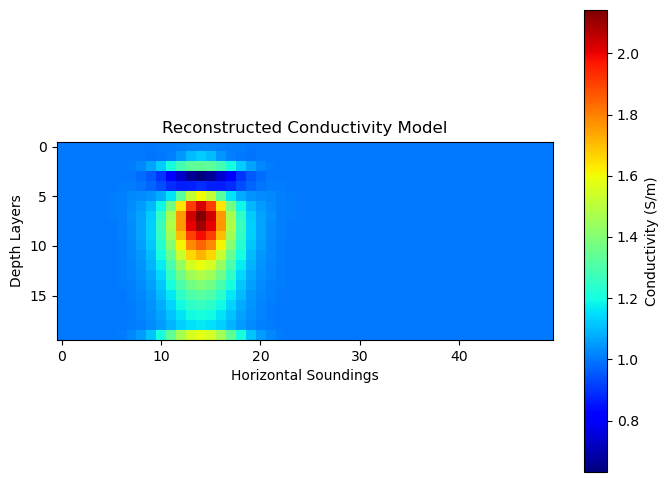

In [13]:
plt.figure(figsize=(8, 6))
plt.imshow(sigma_k, aspect='equal', cmap='jet')
plt.colorbar(label="Conductivity (S/m)")
plt.xlabel("Horizontal Soundings")
plt.ylabel("Depth Layers")
plt.title("Reconstructed Conductivity Model")
plt.show()